# **Analysis**

## **0. Configure environment**
### **0.1 Install all dependencies**

In [22]:
# %%capture
# %pip install pandas==2.0.1
# %pip install seaborn==0.12.2
# %pip install sentence-transformers==2.2.2

### **0.2 Import all the libraries needed for this notebook**

In [23]:
# TO AID WITH REPRODUCIBILITY...
# ENVIRONMENT ============================= #
# Python                             3.11.3 #
#                                           #
# LIBRARIES ------------------------------- #
# pandas                              2.0.1 #
# seaborn                            0.12.2 #
# sentence-transformers               2.2.2 #
# ========================================= #

# python libraries ------------------------ #
import re
import os
import random

# pandas ---------------------------------- #
import pandas

# seaborn --------------------------------- #
import seaborn

# sentence_transformers ------------------- #
from sentence_transformers import SentenceTransformer, util

import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot

### **0.3 Specify all needed constants**
This allows the notebook to be configured in a single spot rather than having to jump around the code base.

In [24]:
# file paths ------------------------------ #
GROUND_TRUTH_FILE_PATH = 'in/ground.json'

RESPONSES_FILE_PATH = f'out/1-base.jsonl'
# RESPONSES_FILE_PATH = f'out/1-baseline-temp-0.jsonl'
# RESPONSES_FILE_PATH = f'out/1-baseline-top-p-0.1.jsonl'

GRADED_FILE_PATH = f'out/2-graded.jsonl'
EMBEDDING_FILE_PATH = f'out/3-embeddings.jsonl'

GROUND_INDEX = 'qid'
RESPONSES_INDEX = 'question_id'

CHOICE_COLUMN = 'choices'
ANSWER_COLUMN = 'answer'

RESPONSES_COLUMNS_TO_KEEP = ['question_id', 'choices', 'usage']
GROUND_COLUMNS_TO_KEEP = ['qid', 'answer']

SAMPLE_COLUMN = 'sample_[index]'

N_JOBS = 20

ALL_MIN_LM_16 = "all_min_lm_16"
ALL_MPNET_BASE_V2 = "all-mpnet-base-v2"

In [25]:
def sample_column(index):
    return f'sample_{index}'

def correct_column(index):
    return f'{sample_column(index)}__is_correct'

def embedding_column(index, transformer_name):
    return f'{sample_column(index)}__{transformer_name}'

## **1. Load data**
### **1.1 Load data from files**

In [26]:
ground = pandas.read_json(GROUND_TRUTH_FILE_PATH)
ground = ground[GROUND_COLUMNS_TO_KEEP]
ground.head(1)

,qid,answer
0,e0044a7b4d146d611e73,False


In [27]:
responses = pandas.read_json(RESPONSES_FILE_PATH, lines=True)
responses = responses[RESPONSES_COLUMNS_TO_KEEP]
responses = responses.join(other=ground.set_index(GROUND_INDEX), on=RESPONSES_INDEX)
responses.head(1)

,question_id,choices,usage,answer
0,c69397b4341b65ed080f,"[{'message': {'role': 'assistant', 'content': ...","{'prompt_tokens': 111, 'completion_tokens': 35...",True


### **1.2 Extract choices into individual columns**

In [28]:
def extract_choices(row):
    choices = row[CHOICE_COLUMN]
    random.shuffle(choices)
    for index in range(len(choices)): 
        row[sample_column(index)] = choices[index]['message']['content']
    return row

responses = responses.apply(lambda row : extract_choices(row), axis=1)
responses.head(1)

,question_id,choices,usage,answer,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,...,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49
0,c69397b4341b65ed080f,"[{'message': {'role': 'assistant', 'content': ...","{'prompt_tokens': 111, 'completion_tokens': 35...",True,The answer is Yes.,The answer is Yes.,The answer is Yes.,The answer is Yes.,The answer is Yes.,The answer is Yes.,...,The answer is Yes.,The answer is Yes.,The answer is Yes.,The answer is Yes.,The answer is Yes.,The answer is Yes.,The answer is yes.,The answer is Yes.,The answer is Yes.,The answer is Yes.


### **1.3 Compute API costs**

In [29]:
total_tokens = responses['usage'].apply(lambda row : row['total_tokens']).sum()
total_cost = total_tokens / 1000 * 0.002
print("TOTAL TOKENS:", total_tokens)
print("TOTAL COST  :", total_cost)

TOTAL TOKENS: 646381
TOTAL COST  : 1.292762


## **2. Grading**
### **2.1 Retrieve cached results (if they exist)**

In [30]:
if not os.path.isfile(GRADED_FILE_PATH): responses.to_json(GRADED_FILE_PATH, orient='records', lines=True)

### **2.2 Evaluate ChatGPT's response**
In our prompts to ChatGPT, we specified for ChatGPT to end its response with the phrase:  
'The answer is...', we look for this string in the final answer and check for the words yes or no after the sentence.

In [31]:
def is_choice_correct(choice : str, answer : bool): 
    lowered_choice = choice.lower()
    extracted_response = str(re.search(r'the answer is.*', lowered_choice))

    result = None
    if answer: result = extracted_response.count('yes') > 0
    else: result = extracted_response.count('no') > 0

    if result: return 1
    else: return 0

def grade_choices(row : pandas.Series):
    choices = row[CHOICE_COLUMN]
    for index in range(len(choices)): 
        if correct_column(index) in set(row.keys()): continue
        row[correct_column(index)] = is_choice_correct(row[sample_column(index)], row[ANSWER_COLUMN])
    return row

graded = pandas.read_json(GRADED_FILE_PATH, lines=True)
graded = graded.combine_first(responses)
graded = graded.apply(lambda row : grade_choices(row), axis=1)
graded.head(1)

,answer,choices,question_id,sample_0,sample_0__is_correct,sample_1,sample_10,sample_10__is_correct,sample_11,sample_11__is_correct,...,sample_5__is_correct,sample_6,sample_6__is_correct,sample_7,sample_7__is_correct,sample_8,sample_8__is_correct,sample_9,sample_9__is_correct,usage
0,True,"[{'message': {'role': 'assistant', 'content': ...",c69397b4341b65ed080f,The answer is Yes.,1,The answer is Yes.,The answer is Yes.,1,The answer is: Yes.,1,...,1,The answer is Yes.,1,The answer is yes.,1,The answer is Yes.,1,"Yes, the language used in Saint Vincent and th...",1,"{'prompt_tokens': 111, 'completion_tokens': 35..."


### **2.3 Cache results**

In [32]:
graded.to_json(GRADED_FILE_PATH, orient='records', lines=True)

## **3. Data exploration**

[Text(0, 0.5, 'Number of correct samples')]

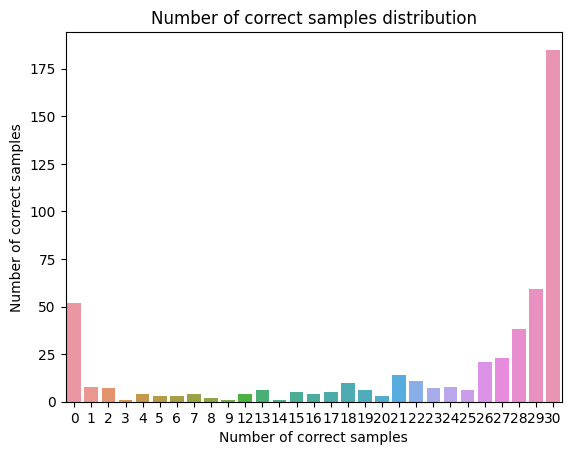

In [33]:
def get_choice_correct_count(row):
    count = 0
    for index in range(N_JOBS): 
        count += row[correct_column(index)]
    return count

counts = graded.apply(lambda row : get_choice_correct_count(row), axis=1)
stats = counts.value_counts().sort_index()
barplot = seaborn.barplot(x=stats.index, y=stats.values)
barplot.set(title="Number of correct samples distribution")
barplot.set(xlabel="Number of correct samples")
barplot.set(ylabel="Number of correct samples")
# for i in barplot.containers:
#     barplot.bar_label(i,)

In [34]:
# graded['counts'] = counts
# graded.to_json('a.jsonl', lines=True, orient='records')

In [35]:
(pandas.Series(stats.index) * stats.values).sum() / N_JOBS

379.2

## **4. Embedding**
### **4.1 Retrieve cache results (if they exist)**

In [36]:
if not os.path.isfile(EMBEDDING_FILE_PATH): graded.to_json(EMBEDDING_FILE_PATH, orient='records', lines=True)

### **4.2 Initialize all the transformers that will be used**

In [37]:
all_mini_lm_l6_v2 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [38]:
def sentence_transformer_encode_choices(row : pandas.Series, transformer : SentenceTransformer, transformer_name):
    choices = row[CHOICE_COLUMN]
    for index in range(len(choices)): 
        if embedding_column(index, transformer_name) in set(row.keys()): continue
        row[embedding_column(index, transformer_name)] = transformer.encode(row[sample_column(index)])
    return row

embedding = pandas.read_json(EMBEDDING_FILE_PATH, lines=True)
embedding = embedding.combine_first(graded)

embedding = embedding.apply(lambda row : sentence_transformer_encode_choices(row, all_mini_lm_l6_v2, ALL_MIN_LM_16), axis=1)
embedding.head(1)

,answer,choices,question_id,sample_0,sample_0__all_min_lm_16,sample_0__is_correct,sample_1,sample_10,sample_10__all_min_lm_16,sample_10__is_correct,...,sample_7,sample_7__all_min_lm_16,sample_7__is_correct,sample_8,sample_8__all_min_lm_16,sample_8__is_correct,sample_9,sample_9__all_min_lm_16,sample_9__is_correct,usage
0,True,"[{'message': {'role': 'assistant', 'content': ...",c69397b4341b65ed080f,The answer is Yes.,"[-0.0203115288, 0.127964139, 0.0320141464, 0.0...",1,The answer is Yes.,The answer is Yes.,"[-0.0203115288, 0.127964139, 0.0320141464, 0.0...",1,...,The answer is yes.,"[-0.0203115288, 0.127964139, 0.0320141464, 0.0...",1,The answer is Yes.,"[-0.0203115288, 0.127964139, 0.0320141464, 0.0...",1,"Yes, the language used in Saint Vincent and th...","[0.0567784943, -0.011504123000000002, -0.07668...",1,"{'prompt_tokens': 111, 'completion_tokens': 35..."


### **4.3 Cache embeddings**

In [39]:
embedding.to_json(EMBEDDING_FILE_PATH, orient='records', lines=True)

## **5. Sample selection**
### **5.1 Clustering**

In [40]:
all_mini_lm_16_scores = []
average_scores = []
temp_0_scores = []
top_p_scores = []

# SCORES OF BASELINE AVERAGED OVER 5 SAMPLES
TEMP_0 = 304.8
TOP_P = 381.2

for n_jobs in range(1, N_JOBS + 1):
    def select_by_clustering(row, transformer_name):
        embeddings = []
        for index in range(n_jobs): embeddings.append(row[embedding_column(index, transformer_name)])

        kmeans = KMeans(n_clusters=1, n_init=2)
        kmeans.fit_predict(embeddings)

        centroid = kmeans.cluster_centers_[0]

        min_distance = float('inf')
        min_sample = correct_column(0)

        for index, el in enumerate(embeddings):
            distance = np.linalg.norm(centroid - el)
            if distance < min_distance: 
                min_distance = distance
                min_sample = correct_column(index)
        return row[min_sample]
    
    def get_choice_correct_count(row):
        total = 0
        for index in range(n_jobs): total += row[correct_column(index)]
        return total
     
    clustering = embedding.apply(lambda row : select_by_clustering(row, ALL_MIN_LM_16), axis=1)
    all_mini_lm_16_scores.append(clustering.sum())

    temp_0_scores.append(TEMP_0)
    top_p_scores.append(TOP_P)
    
    average_performance = embedding.apply(lambda row : get_choice_correct_count(row), axis=1).sum() / n_jobs
    average_scores.append(average_performance)

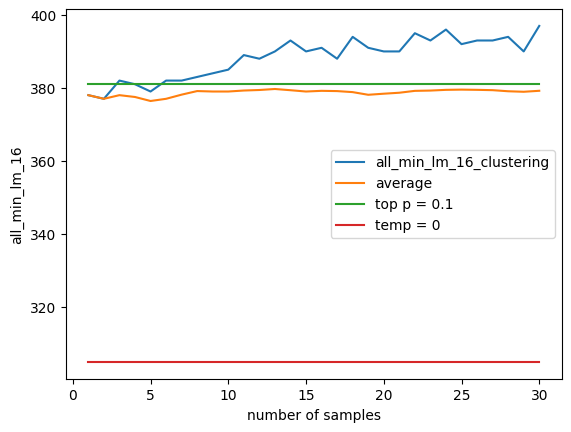

In [41]:
disp = pandas.DataFrame()
disp['number of samples'] = pandas.Series(range(1, N_JOBS + 1))
disp['average'] = pandas.Series(average_scores)
# disp['top p = 0.1'] = pandas.Series(top_p_scores)
# disp['temp = 0'] = pandas.Series(temp_0_scores)
disp[ALL_MIN_LM_16] = pandas.Series(all_mini_lm_16_scores)

seaborn.lineplot(data=disp, x='number of samples', y=ALL_MIN_LM_16, label=f'{ALL_MIN_LM_16}_clustering')
seaborn.lineplot(data=disp, x='number of samples', y='average', label='average')
# seaborn.lineplot(data=disp, x='number of samples', y='top p = 0.1', label='top p = 0.1')
# seaborn.lineplot(data=disp, x='number of samples', y='temp = 0', label='temp = 0')
pyplot.show()